In [1]:
import os, time, errno
import torch, tables
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='0'
savedir = '32x32-convnet-scrambled-inputs'

In [3]:
T = 10 # time buckets

hdf5 = tables.open_file('captures/fei/R1_E3_AMES_200min_200f_14l_rgb.h5','r')
hdf5 = hdf5.root

try:
    dataset = np.load('captures/fei/cache.npy')
except FileNotFoundError:

    data = []
    for i in range(7):
        print('.',end='')
        batch = np.array(hdf5['data'][i*400:(i+1)*400])
        batch = batch.reshape(-1,T,int(batch.shape[1]/T),64,64,6).sum(2).astype(np.float32) # binning
        data.append(batch)
        
    dataset = np.concatenate(data,axis=0)
    dataset = np.moveaxis(dataset,[0,1,2,3,4],[0,1,3,4,2])
    np.save('captures/fei/cache.npy', dataset)
    
classes = np.array([np.array(itm.decode('utf-8').split('"'))[[1,3]].astype(np.int32)
                    for itm in np.array(hdf5['image_classes'].read())])

# Presented targets

In [4]:
imgs = hdf5["images"][0:100]
y,x = np.where(np.mean(imgs, axis=(0,3))>5)
xleft, xright, ytop, ybot = min(x), max(x), min(y), max(y)

images = hdf5["images"][:,ytop:ybot,xleft:xright]

tiny_images = []
for i in range(len(images)):
    tiny_images.append(cv2.resize(images[i],(64,64)))
images = np.stack(tiny_images)

# Model

In [5]:
class Block(torch.nn.Module):
    def __init__(self, filters):
        super(Block, self).__init__()
        
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters), torch.nn.ReLU(),
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters))
        
    def forward(self, x):
        return F.relu(x + self.block(x))
    
class ConvNet(torch.nn.Module):
    def __init__(self, filters=512):
        super(ConvNet, self).__init__()
        self.filters = filters
        
        self.conv_in = torch.nn.Conv2d(10*6, filters, 9, padding=4, stride=4, bias=False)
        
        self.resnet = torch.nn.ModuleList()
        for i in range(101): self.resnet.append(Block(filters))
            
        self.conv_out =  torch.nn.ConvTranspose2d(self.filters, 1, 8, stride=8, bias=True)
        self.bias = torch.nn.Parameter(torch.Tensor(64,64))
        
        for name, parm in self.named_parameters():
            if name.endswith('weight'): torch.nn.init.normal_(parm, 0, .01)
            if name.endswith('bias'): torch.nn.init.constant_(parm, 0.0)
    
    def forward(self, x):
        x = x.view(-1,10*6,64,64)[:,:,::2,::2].contiguous()
        zx = F.relu(self.conv_in(x))
        for layer in self.resnet: zx = layer(zx)
        return torch.sigmoid(self.conv_out(zx).squeeze() + self.bias[None,:,:])

# Fit

In [6]:
data = torch.tensor(dataset)/30. # scaling
targets = torch.tensor(images).float().mean(3)/255.
order = np.random.permutation(range(64*64))

In [7]:
train_data = data[[i for i in range(2800) if (i+1)%5 != 0]]
val_data = data[slice(4,2800,10)]
test_data = data[slice(9,2800,10)]

train_targets = targets[[i for i in range(2800) if (i+1)%5 != 0]]
val_targets = targets[slice(4,2800,10)]
test_targets = targets[slice(9,2800,10)]

In [8]:
train_data = train_data.contiguous().view(-1,64*64)[:,order].view(-1,10,6,64,64)
val_data = val_data.contiguous().view(-1,64*64)[:,order].view(-1,10,6,64,64)
test_data = test_data.contiguous().view(-1,64*64)[:,order].view(-1,10,6,64,64)

In [9]:
batch_size = 8

model = ConvNet().cuda()
count = sum([np.prod(parm.shape) for parm in model.parameters() if parm.requires_grad])
print('Initialized a graph with {} parameters'.format(count))

train_history = []
val_history = []

model.eval()
loss = 0.
for i in np.random.permutation(len(val_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).sum(1).mean()
val_history.append(loss/(len(val_data)//batch_size))
print('Initial Loss: {:2f}'.format(val_history[-1]))

Initialized a graph with 479309825 parameters
Initial Loss: 4.071651


In [10]:
batch_size = 8
optimizer = torch.optim.Adam(model.parameters(), lr=.0003)

try:
    print('epoch\ttrain loss\ttest loss\ttime\t\tutime')
    t0 = time.time()
    for epoch in range(500):
        model.train()
        loss_train = 0
        for i in np.random.permutation(len(train_data)//batch_size):
            start, end = i*batch_size, (i+1)*batch_size
            x,z = train_data[start:end].cuda(), train_targets[start:end].cuda()
            loss = ((model(x) - z)**2).sum(1).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.detach()
        train_history.append(loss_train/(len(train_data)//batch_size))

        if epoch % 1 == 0:
            t1 = time.time()
            model.eval()
            loss = 0.
            for i in range(len(val_data)//batch_size):
                start, end = i*batch_size, (i+1)*batch_size
                x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
                loss += ((model(x).detach() - z)**2).sum(1).mean()
            val_history.append(loss/(len(val_data)//batch_size))
            print('{:d}\t{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(epoch,train_history[-1],val_history[-1],time.time()-t0, time.time()-t1))
            t0 = time.time()
            
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print('Finished')

epoch	train loss	test loss	time		utime
0	1.461357	2.142266	84.614241	2.267984
1	1.083176	1.684512	87.468564	2.336373
2	0.922122	1.525093	89.004580	2.374855
3	0.800709	2.258373	89.015599	2.372307
4	0.720129	1.587577	88.768447	2.364349
5	0.664558	1.341279	88.633584	2.361731
6	0.591047	1.486614	88.614407	2.352197
7	0.531536	1.284788	88.599426	2.348382
8	0.483412	1.985607	88.551924	2.343924
9	0.449387	1.373274	88.613690	2.347365
10	0.419481	1.521917	88.545733	2.350131
11	0.385296	1.310906	88.567082	2.362331
12	0.362348	1.177947	88.635545	2.363285
13	0.345997	1.327464	88.662079	2.346498
14	0.330286	1.147339	88.597340	2.362176
15	0.312542	1.316910	88.633778	2.361133
16	0.298969	1.389285	88.627169	2.362913
17	0.281495	1.148473	88.600181	2.362480
18	0.268001	1.093350	88.567890	2.365558
19	0.255392	1.236562	88.631587	2.367935
20	0.242534	1.239359	88.525400	2.359982
21	0.227947	1.269354	88.536912	2.366894
22	0.219545	0.975598	88.512521	2.346814
23	0.211607	1.324513	88.402692	2.330148
24	0.203218

202	0.004905	1.213211	88.553311	2.356741
203	0.005191	1.313035	88.533608	2.365462
204	0.005847	1.391914	88.529600	2.356418
205	0.006763	1.231624	88.530005	2.362534
206	0.007220	1.323977	88.540845	2.362301
207	0.006939	1.287591	88.674640	2.354786
208	0.006459	1.315387	88.439712	2.335320
209	0.005985	1.320081	88.269781	2.316587
210	0.005417	1.169763	88.358942	2.333549
211	0.005085	1.237155	88.475010	2.363347
212	0.005210	1.186424	88.553807	2.359979
213	0.005903	1.327067	88.523738	2.363627
214	0.006486	1.244011	88.632539	2.362704
215	0.006744	1.218312	88.540025	2.361170
216	0.006368	1.662266	88.587891	2.351129
217	0.005761	1.137663	88.559037	2.358860
218	0.005196	1.085975	88.553003	2.367676
219	0.004807	1.202447	88.623201	2.364516
220	0.004584	1.184015	88.632499	2.360128
221	0.004682	1.069351	88.367546	2.313795
222	0.005205	1.488530	88.304216	2.312332
223	0.005878	1.197651	88.405368	2.357841
224	0.007083	1.216211	88.531317	2.358840
225	0.007290	1.272849	88.611021	2.378570
226	0.008467	1.2

402	0.003115	1.215393	88.418978	2.364285
403	0.002785	1.435109	88.431561	2.363714
404	0.002448	1.173653	88.422490	2.364656
405	0.002152	1.156137	88.430396	2.362685
406	0.002087	1.273423	88.435531	2.363814
407	0.002167	1.259615	88.422202	2.364653
408	0.002448	1.219573	88.500057	2.342796
409	0.002806	1.015108	88.366943	2.362157
410	0.002971	1.199479	88.420342	2.363781
411	0.002874	1.216776	88.408036	2.344352
412	0.002552	1.245674	88.336949	2.322067
413	0.002255	1.357335	88.265693	2.319435
414	0.002063	1.439402	88.393313	2.357473
415	0.002135	1.278412	88.439049	2.366874
416	0.002330	1.147333	88.422895	2.360982
417	0.002607	1.327362	88.433565	2.367968
418	0.002799	1.187680	88.426010	2.365170
419	0.002698	1.101934	88.420926	2.354660
420	0.002492	1.081277	88.440323	2.363573
421	0.002274	1.393624	88.417558	2.359861
422	0.002145	1.251514	88.426858	2.357300
423	0.002157	1.110649	88.439951	2.371248
424	0.002403	1.145496	88.520640	2.363041
425	0.002593	1.350412	88.378683	2.322269
426	0.002677	1.4

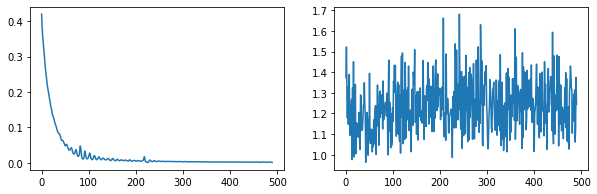

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].plot(train_history[10:])
ax[1].plot(val_history[10:])

In [12]:
model.eval()
loss = 0.
for i in np.random.permutation(len(test_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = test_data[start:end].cuda(), test_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).view(-1,64*64).sum(1).mean()
print('Final Loss: {:2f}'.format(loss/(len(test_data)//batch_size)))

Final Loss: 75.209671


In [23]:
try:
    os.makedirs(f'final-outputs/{savedir}')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

train_idx = 0
val_idx = 0
test_idx = 0
for i in range(len(data)):
    person, pose = classes[i]
    if (i+1) % 5 != 0: # training data
        prefix = f'train{train_idx}'
        train_idx += 1
    elif (i+1) % 10 == 5: # validation data
        prefix = f'valid{val_idx}'
        val_idx += 1
    else: # (i+1) % 10 == 0 (test data)
        prefix = f'test{test_idx}'
        test_idx += 1
    
    recon = model(data[i].view(-1,64*64)[:,order].view(10,6,64,64).cuda()).detach().cpu()[0]
    recon = recon.numpy()
    cv2.imwrite(f'final-outputs/{savedir}/{prefix}-person{person}-pose{pose}.png', 255*recon)

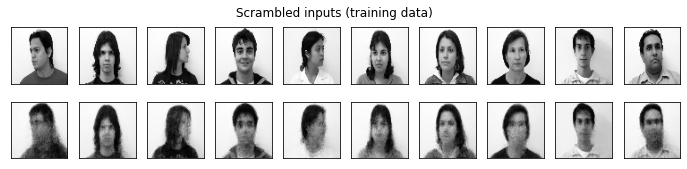

In [13]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))
fig.suptitle('Scrambled inputs (training data)')

model.eval()
reconstructions = model(train_data[0:10].cuda()).detach().cpu()
for i in range(10):
    ax[0,i].imshow(train_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])

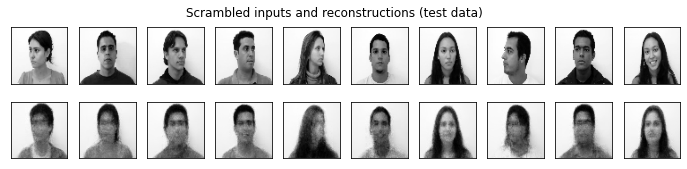

In [14]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))
fig.suptitle('Scrambled inputs and reconstructions (test data)')

model.eval()
reconstructions = model(test_data[0:10].cuda()).detach().cpu()
for i in range(10):    
    ax[0,i].imshow(test_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])